In [1]:
#basic libraries
import h2o
import numpy as np
import pandas as pd
import re
import joblib

#helper functions
import helper

#scikit-learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('data/after_single_var_eda.csv')

# Relationship between variables
Before I examine the relationship between variables, I will do some data cleaning first to make sure that the plots generated will be more readable. This data cleaning part will be everything mentioned above except for data imputation.

The tasks to do are:
1. Examining duplicated data
2. Dealing with the extreme values in the current_loan_amount column
3. Fix the values in the credit_score which are more than 850
4. Map the values in the years_in_current_job column to numbers, but change the type into categorical
5. Change the value HaveMortage to Home Mortgage in the home_ownership column
6. Convert all the string values in all of the column into snake case, all lowercase.
7. Change the extreme value in the maximum_open_credit column into NaN value, and impute it later

## Data Cleaning
### 1. Examining duplicates
The crucial columns that cannot have duplicates is Loan ID. If it has duplicates, it indicates double input because ID needs to be unique. Furthermore, for every Loan ID, there can only be one customer. If there are 2 or more customers with the same Loan ID, it indicates that there are errors in inputting the data. These needs to be dropped. 

In [3]:
#dropping all duplicated columns
df.drop_duplicates(inplace = True)

#examining duplicates in the loan_id column
duplicate_rows = df[df.duplicated(subset=['loan_id'], keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by='loan_id')
duplicate_rows_sorted.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
97429,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719,Short Term,724.0,1 year,Own Home,34297.0,Home Improvements,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0
32050,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719,Short Term,NaN,1 year,Own Home,NaN,Home Improvements,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0
32216,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Loan Given,1433,Short Term,NaN,10+ years,Home Mortgage,NaN,Home Improvements,2627.76,15.1,5.0,22,0,27706,49563.0,0.0,0.0
97876,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Loan Given,1433,Short Term,716.0,10+ years,Home Mortgage,108735.0,Home Improvements,2627.76,15.1,5.0,22,0,27706,49563.0,0.0,0.0
96169,000dbdf1-3926-4676-bb4f-fe40c242a46e,5165c688-1669-43e9-88b5-db212c72655c,Loan Given,34185,Long Term,717.0,3 years,Home Mortgage,88880.0,Debt Consolidation,1881.29,25.9,NaN,20,0,37507,50961.0,0.0,0.0


In [4]:
duplicate_rows.shape

(19342, 19)

In [5]:
#checking whether there are double customer_ids for every loan_id
count_different_customer_ids = duplicate_rows_sorted.groupby('loan_id')['customer_id'].nunique()
count_different_customer_ids = count_different_customer_ids[count_different_customer_ids > 1]
print(f'There are {len(count_different_customer_ids)} duplicated customers for every loan_id')

There are 0 duplicated customers for every loan_id


There are no duplicated customers for every loan_id. Therefore, I need to just group the loan_id and take the non-null values and non-extreme values. For example, the rows below:

In [6]:
df[df['loan_id'] == '000ea0cb-8d0e-4284-b8c8-444ffbbe4caf']

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
11541,000ea0cb-8d0e-4284-b8c8-444ffbbe4caf,db069b01-22c0-4b77-8b0a-b5704a0fd451,Loan Given,99999999,Short Term,715.0,10+ years,Rent,86437.0,Debt Consolidation,2204.13,18.0,NaN,22,0,21135,34366.0,0.0,0.0
108034,000ea0cb-8d0e-4284-b8c8-444ffbbe4caf,db069b01-22c0-4b77-8b0a-b5704a0fd451,Loan Given,21075,Short Term,715.0,10+ years,Rent,86437.0,Debt Consolidation,2204.13,18.0,NaN,22,0,21135,34366.0,0.0,0.0


the correct current_loan_amount should be 21075 instead of 99999999.

In [7]:
def handle_value(values):
    non_nan_values = [value for value in values if not pd.isna(value)]
    if any(isinstance(value, str) for value in non_nan_values):
        return non_nan_values[0]  # Return the first non-NaN string value
    else:
        non_extreme_values = [value for value in non_nan_values if value != 99999999]
        return non_extreme_values[0] if non_extreme_values else np.nan

In [8]:
df_agg = df.groupby('loan_id').agg(handle_value).reset_index()

In [9]:
#the duplicates within loan_id
df_agg[df_agg['loan_id'].duplicated()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens


In [10]:
#the duplicated columns
df_agg[df_agg.duplicated()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens


In [11]:
df_agg.shape

(88908, 19)

### 2. Dealing with the extreme values in the current_loan_amount column

In [12]:
df_agg[df_agg.current_loan_amount == df_agg.current_loan_amount.max()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
27925,4fed402f-4298-4f5c-8d30-05b1f1819c00,84be9ce6-bf8d-47ee-829c-65b989433419,Loan Given,35875.0,Long Term,672.0,10+ years,Rent,92250.0,Debt Consolidation,1537.50,8.5,NaN,11,0,51132,69948.0,0.0,0.0
41456,770ca5a2-3b53-4c8c-a238-55cf72f66b82,e2615a86-9f65-43dd-88f2-e283bb99b7f4,Loan Refused,35875.0,Short Term,NaN,2 years,Home Mortgage,NaN,Debt Consolidation,908.84,21.0,NaN,8,0,21202,34872.0,0.0,0.0
63942,b7923e12-395b-49d6-97ee-ca0ed25b65c2,5c167711-571f-4dc9-b74c-2a53edca449a,Loan Given,35875.0,Short Term,721.0,6 years,Home Mortgage,423920.0,Debt Consolidation,6005.53,31.4,2.0,21,0,96113,109344.0,0.0,0.0


Apparently, dropping the duplicates also fix the extreme values in the current_loan_amount column.

### 3. Fix the values in the credit_score which are more than 850

In [13]:
df_agg.credit_score.describe()

count    72819.000000
mean      1163.058391
std       1623.983807
min        585.000000
25%        711.000000
50%        731.000000
75%        743.000000
max       7510.000000
Name: credit_score, dtype: float64

In [14]:
df_agg.loc[df_agg['credit_score'] > 850, 'credit_score'] = df_agg.loc[df_agg['credit_score'] > 850, 'credit_score'] / 10
print(f"The maximum number of credit score is now {df_agg.credit_score.max()}") 

The maximum number of credit score is now 751.0


### 4. Map the values in the years_in_current_job column to numbers, but change the type into categorical

In [15]:
mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

years_in_current_job_filename = 'model/years_in_current_job_mapping.pkl'
joblib.dump(mapping, years_in_current_job_filename)

df_agg['years_in_current_job'] = df_agg['years_in_current_job'].map(mapping)
df_agg['years_in_current_job'] = df_agg.years_in_current_job.astype('category')
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88908 entries, 0 to 88907
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   loan_id                       88908 non-null  object  
 1   customer_id                   88908 non-null  object  
 2   loan_status                   88908 non-null  object  
 3   current_loan_amount           80592 non-null  float64 
 4   term                          88908 non-null  object  
 5   credit_score                  72819 non-null  float64 
 6   years_in_current_job          85091 non-null  category
 7   home_ownership                88908 non-null  object  
 8   annual_income                 72819 non-null  float64 
 9   purpose                       88908 non-null  object  
 10  monthly_debt                  88908 non-null  float64 
 11  years_of_credit_history       88908 non-null  float64 
 12  months_since_last_delinquent  40402 non-null  

### 5. Change the value HaveMortage to Home Mortgage in the home_ownership column

In [16]:
df_agg[df_agg['home_ownership'] == 'HaveMortgage'].head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
72,003665f5-adff-4fbb-903c-14d022fa6a08,80c0ee25-ec87-4e1f-aefc-e5bbd679cef1,Loan Given,1986.0,Short Term,719.0,9.0,HaveMortgage,35741.0,Take a Trip,452.72,11.0,69.0,5,5,856,7924.0,1.0,4.0
91,00434fa8-4473-4fde-9116-5fa02bbb46d4,f5f39047-dadd-4a0b-8016-d77ad2107c5d,Loan Given,NaN,Short Term,740.0,7.0,HaveMortgage,39076.0,Take a Trip,729.42,22.6,NaN,13,0,22151,24917.0,0.0,0.0
779,024bf769-1d1b-4af9-895e-e96aa07e9e14,37886523-ce0a-47bc-ae79-2e96f10bfd96,Loan Refused,975.0,Short Term,694.0,10.0,HaveMortgage,59599.0,Take a Trip,1157.22,27.2,3.0,12,0,17869,25859.0,0.0,0.0
1096,0330fe14-af97-41f9-a564-6ec542655a26,c90c0665-80a3-4705-b9db-5e325297fe2c,Loan Given,9093.0,Long Term,NaN,3.0,HaveMortgage,NaN,Take a Trip,1401.29,23.4,NaN,10,0,4593,6666.0,0.0,0.0
1771,0527b14a-1f6f-44fa-84e1-2e29a4f2a76d,8080d5ed-d14a-4d49-88a8-0071eaa9de68,Loan Given,10163.0,Short Term,705.0,7.0,HaveMortgage,66560.0,Take a Trip,904.11,9.5,NaN,9,0,4079,4404.0,0.0,0.0


In [17]:
df_agg['home_ownership'] = df_agg['home_ownership'].replace('HaveMortgage', 'Home Mortgage')
df_agg.home_ownership.value_counts()

home_ownership
Home Mortgage    43439
Rent             37394
Own Home          8075
Name: count, dtype: int64

### 6. Convert all the string values in all of the column into snake case, all lowercase

In [18]:
def has_non_ascii(s):
    for char in s:
        if ord(char) > 127:
            return True
    return False

df_agg = df_agg.applymap(lambda x: x if not isinstance(x, str) or not has_non_ascii(x) else x.encode('ascii', 'ignore').decode('ascii'))

In [19]:
categorical_cols = ['loan_status', 'term', 'home_ownership', 'purpose']
for col in categorical_cols:
    df_agg[col] = helper.clean_columns(df_agg[col].tolist())

In [20]:
df_agg.purpose.value_counts()

purpose
debt_consolidation      70446
other                    7767
home_improvements        5205
business_loan            1328
buy_a_car                1196
medical_bills             955
buy_house                 559
take_a_trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
educational_expenses       92
vacation                   82
renewable_energy            9
Name: count, dtype: int64

### 7. Change the extreme value in the maximum_open_credit column into NaN value

In [21]:
quantiles = df_agg['maximum_open_credit'].quantile([0.5,0.75,0.95,0.99,1])
threshold = quantiles[0.99]
df_agg['maximum_open_credit'] = np.where(df_agg['maximum_open_credit'] > threshold, np.nan, df_agg['maximum_open_credit'])

In [22]:
df_agg.maximum_open_credit.describe()

count     88016.000000
mean      27709.360173
std       22483.791082
min           0.000000
25%       12693.000000
50%       21568.000000
75%       35776.500000
max      171423.000000
Name: maximum_open_credit, dtype: float64

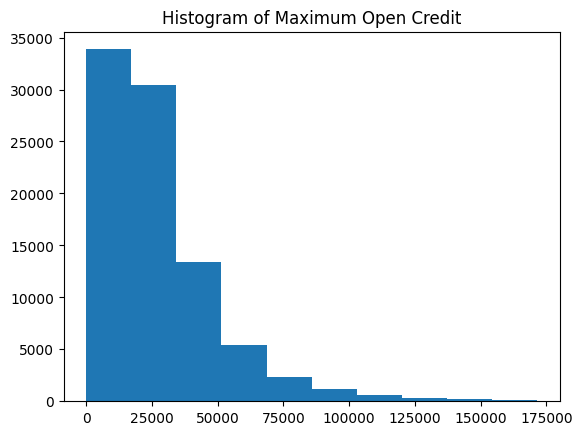

In [23]:
helper.create_histogram(df_agg, 'maximum_open_credit')

## Relationship between predictors and target variable
I will start by examining the relationship between categorical variables to loan_status. For this, I will create a side-by-side stacked bar charts. The first one is using frequency as the y-axis to see the shape of the chart, the second one is using percentage or proportion to see the distribution of the data. 

In [24]:
def create_stacked_barcharts(df, x, y):
    # Create non-normalized crosstab
    table = pd.crosstab(df[x], df[y])
    
    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot non-normalized stacked bar chart
    colors = plt.cm.tab20.colors
    bottom = [0] * len(table.index)
    
    for idx, category in enumerate(table.columns):
        axes[0].bar(
            table.index,
            table[category],
            bottom=bottom,
            label=category,
            color=colors[idx],
        )
        bottom += table[category]
    
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Stacked Barchart of {x} vs {y} (Non-normalized)')
    axes[0].legend()
    
    # Create normalized crosstab
    normalized_table = pd.crosstab(df[x], df[y], normalize='index')
    
    # Plot normalized stacked bar chart
    bottom = [0] * len(normalized_table.index)
    
    for idx, category in enumerate(normalized_table.columns):
        axes[1].bar(
            normalized_table.index,
            normalized_table[category],
            bottom=bottom,
            label=category,
            color=colors[idx],
        )
        bottom += normalized_table[category]
    
    axes[1].set_ylabel('Percentage')
    axes[1].set_title(f'Stacked Barchart of {x} vs {y} (Normalized)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return table, normalized_table

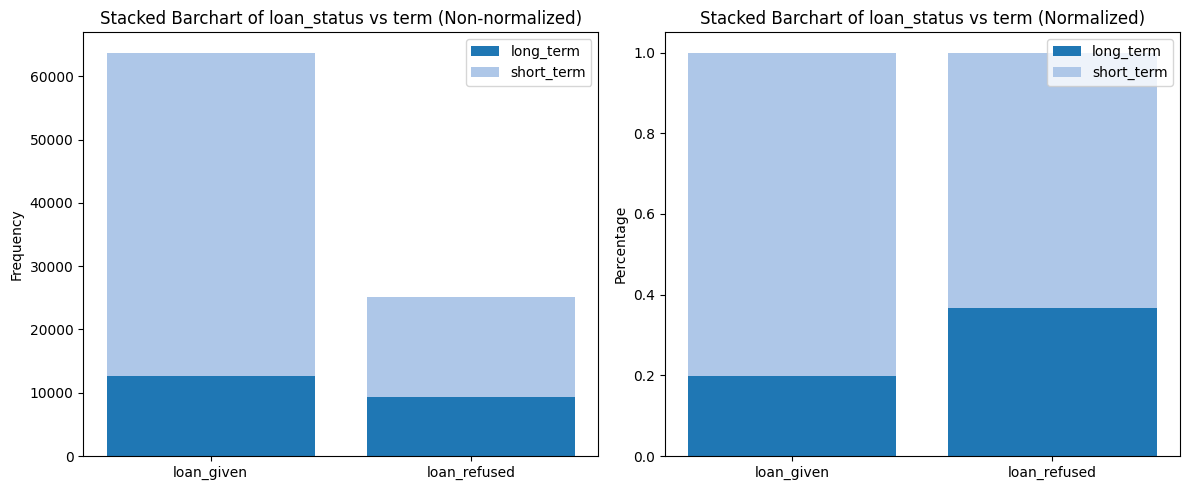

In [25]:
table_term, normalized_table_term = create_stacked_barcharts(df_agg,'loan_status', 'term')

In [26]:
table_term

term,long_term,short_term
loan_status,,
loan_given,12714,51023
loan_refused,9263,15908


In [27]:
normalized_table_term

term,long_term,short_term
loan_status,,
loan_given,0.199476,0.800524
loan_refused,0.368003,0.631997


The chart indicates that there are significantly more loan given than refused. Moreover short term loans are given more than long term. However, more short term loans are also refused compared to long term ones. Given the differences in proportion, term might be a good predictor of loan_status.

Next, I will see the relationship between years in current job and loan status.

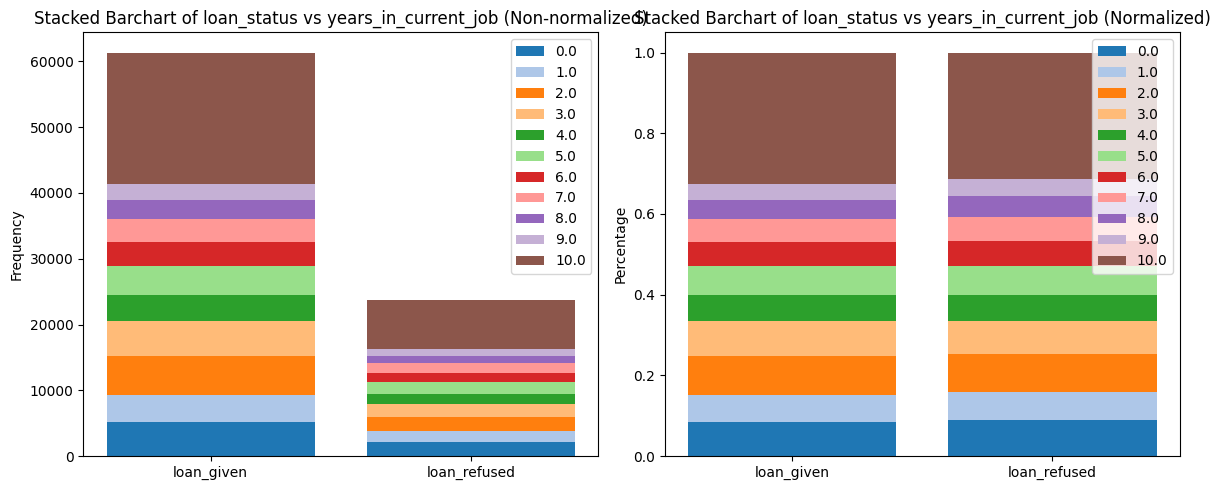

In [28]:
table_years, normalized_table_years = create_stacked_barcharts(df_agg, 'loan_status', 'years_in_current_job')

In [29]:
table_years

years_in_current_job,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
loan_status,,,,,,,,,,,
loan_given,5210,4098,5967,5297,3926,4378,3630,3508,2920,2428,19966
loan_refused,2102,1667,2220,1965,1548,1706,1465,1435,1178,1034,7443


In [30]:
normalized_table_years

years_in_current_job,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
loan_status,,,,,,,,,,,
loan_given,0.084953,0.066821,0.097297,0.086372,0.064016,0.071387,0.05919,0.057201,0.047613,0.039590,0.325561
loan_refused,0.088457,0.070151,0.093423,0.082692,0.065143,0.071792,0.06165,0.060388,0.049573,0.043513,0.313218


Based on the bar chart, more loans are given to people who have worked for more than 10 years. Interestingly, most people who got their loans refused also have worked for 10+ years in their current company.

The data distribution of years_in_current_job is similar between loan_given and loan_refused. This might mean that there's no relationship between years_in_current_job and loan_status, but more statistical tests are needed to confirm it.

Next, I will look at the relationship between home_ownership and loan_status.

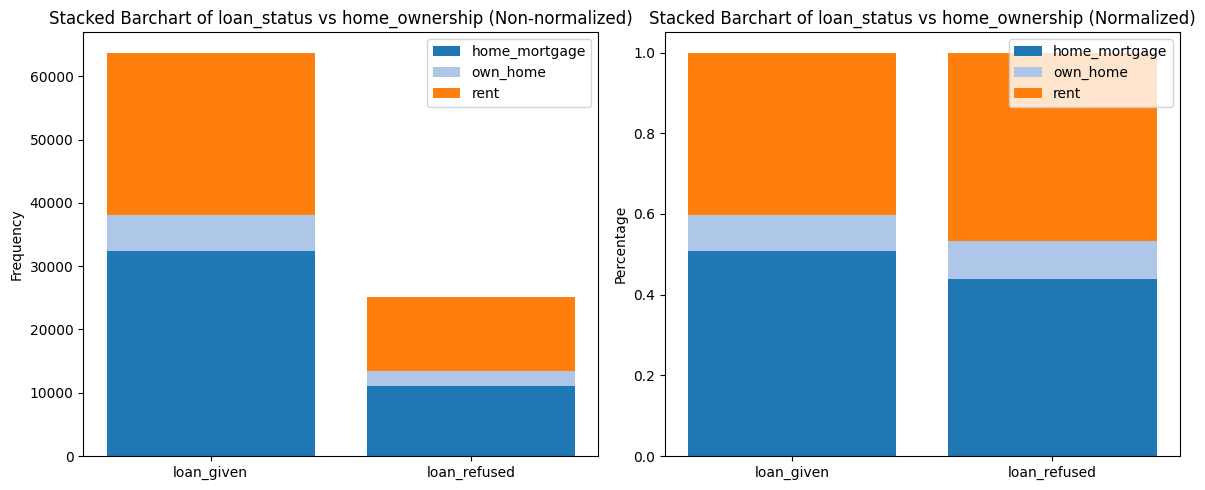

In [31]:
table_home, normalized_table_home = create_stacked_barcharts(df_agg, 'loan_status', 'home_ownership')

In [32]:
table_home

home_ownership,home_mortgage,own_home,rent
loan_status,,,
loan_given,32373,5738,25626
loan_refused,11066,2337,11768


In [33]:
normalized_table_home

home_ownership,home_mortgage,own_home,rent
loan_status,,,
loan_given,0.507915,0.090026,0.402058
loan_refused,0.439633,0.092845,0.467522


Looking at the proportion, I believe that the distribution is slightly different, indicating that this variable might not be a strong predictor to loan_status. However, it has to be noted that this is judged by visually examining the charts and the table, not by statistical method.

Next, I will look at the relationship between loan purpose and loan_status.

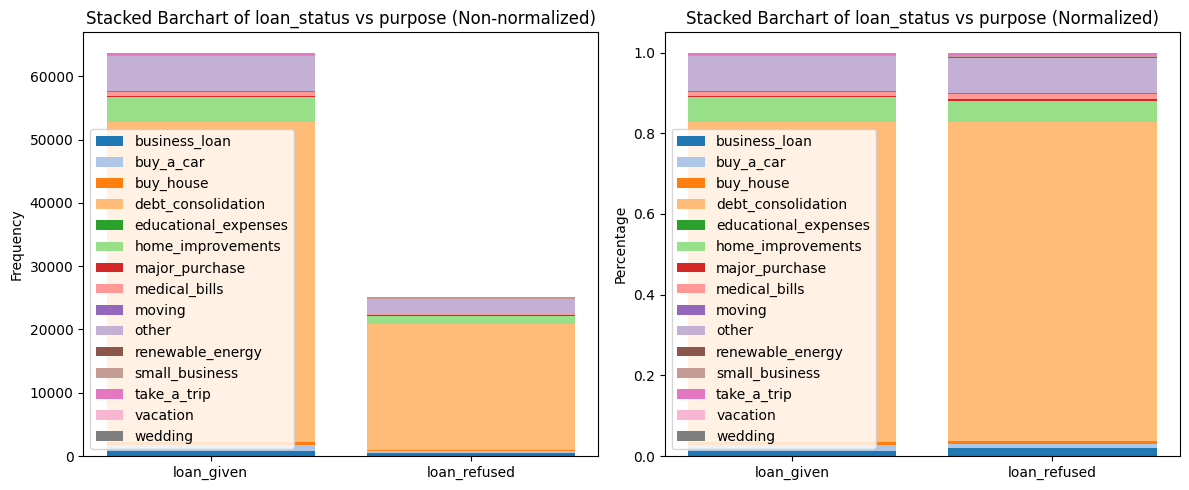

In [34]:
table_purpose, normalized_table_purpose = create_stacked_barcharts(df_agg, 'loan_status', 'purpose')

In [35]:
table_purpose

purpose,business_loan,buy_a_car,buy_house,debt_consolidation,educational_expenses,home_improvements,major_purchase,medical_bills,moving,other,renewable_energy,small_business,take_a_trip,vacation,wedding
loan_status,,,,,,,,,,,,,,,
loan_given,795,962,400,50529,71,3910,245,644,75,5528,5,117,331,52,73
loan_refused,533,234,159,19917,21,1295,99,311,49,2239,4,131,123,30,26


In [36]:
normalized_table_purpose

purpose,business_loan,buy_a_car,buy_house,debt_consolidation,educational_expenses,home_improvements,major_purchase,medical_bills,moving,other,renewable_energy,small_business,take_a_trip,vacation,wedding
loan_status,,,,,,,,,,,,,,,
loan_given,0.012473,0.015093,0.006276,0.792773,0.001114,0.061346,0.003844,0.010104,0.001177,0.086731,0.000078,0.001836,0.005193,0.000816,0.001145
loan_refused,0.021175,0.009296,0.006317,0.791268,0.000834,0.051448,0.003933,0.012355,0.001947,0.088952,0.000159,0.005204,0.004887,0.001192,0.001033


Most loans requested are to do debt consolidations. Both loans given and refused are mostly composed of debts utilized for debt consolidation (79.27% given and 79.12% refused). The proportion of loan given and refused based on the purpose is nearly the same, indicating that purpose might not be a strong predictor for loan status, although more statistical tests are needed to confirm it.

Next, I will examine the relationship between the continuous variables and loan_status. Before doing so, I will look at the relationship between each continuous variables by creating a heatmap.

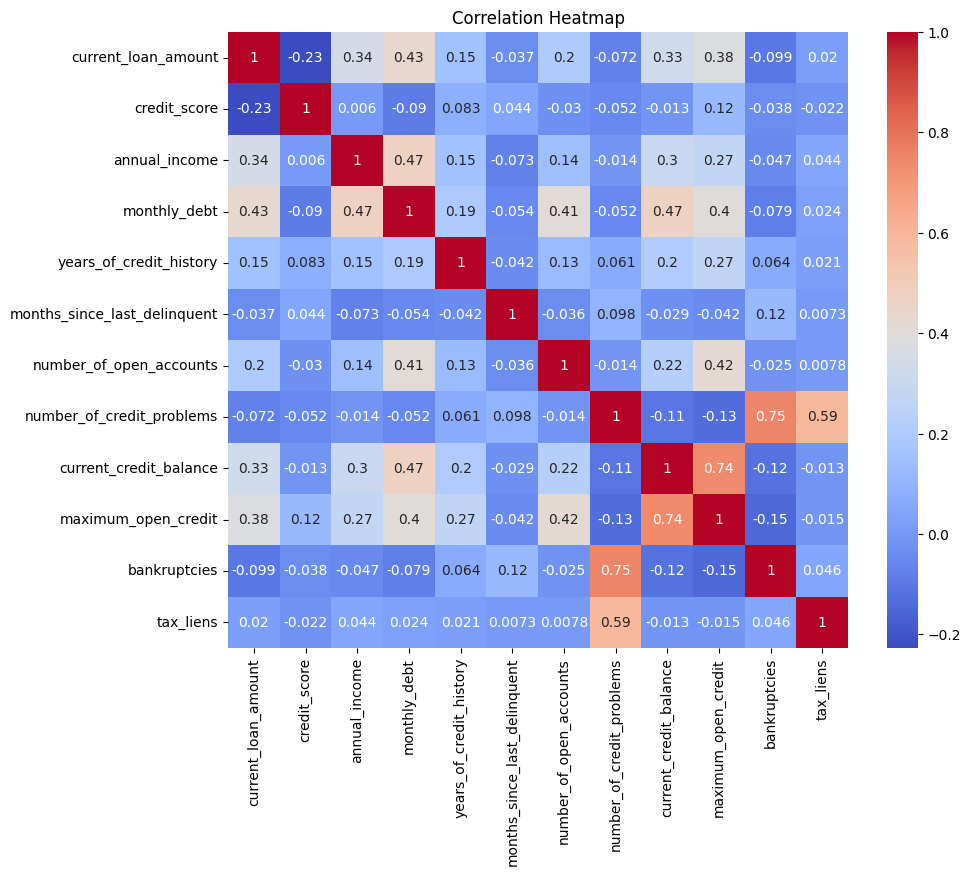

In [37]:
# Correlation Heatmap
corr_matrix = df_agg[['current_loan_amount', 'credit_score', 'annual_income', 'monthly_debt', 'years_of_credit_history', 'months_since_last_delinquent', 'number_of_open_accounts', 'number_of_credit_problems', 'current_credit_balance', 'maximum_open_credit', 'bankruptcies', 'tax_liens']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show();

Judging by the heatmap, the variables which have strong correlations are:

1. number_of_credit_problems and bankruptcies
2. current_credit_balance and maximum_open_credit
3. number_of_credit_problems and tax_liens

First of all, it's logical that people who have more credit problems are more likely to declare bankruptcy. If they can't solve the credit problem, it might lead to them filing for bankruptcies because of the accumulation of debt. It also indicates that they don't have the resources to solve the credit problems and therefore file for bankruptcy. Another reason is that these people might view declaring bankruptcy as a way to break free from their credit problems and get a new start in rebuilding their financial health.

Next, people with higher current credit balance seems to have larger maximum open credit. This means that people who overpaid their loans tend to have higher credit limit as well. There are two possible reasons for this that I can think of. First, being able to overpay their loans indicates that people have financial stability. This might result in the lenders have more confidence that these people are responsible in paying their loans, and therefore give them higher credit limit. Second, this confidence in the borrowers might result in the lenders giving an increase in their credit limit when requested. The rest of the reasons that I can think of has something to do with credit score. However, based on the heatmap, there are weak correlation between current credit balance and credit score.

Lastly, people with higher number of credit problems seems to have higher tax liens. This can happen because these people might prioritize paying their personal loans, such as credit card loans, instead of their taxes. This can result in the increase of the tax liens. Another reason is that these people have a lot of financial problems and they have difficulties in meeting their financial obligations, including tax. This has a potential to result in the increase in tax liens. In short, these people usually have cash flow issues, which render them unable to pay tax, or unable to pay it on time. Thus, the increase in tax liens is highly likely for them.

To examine further, I will create a pair grid plot. I will also add loan_status as the hue to see the relationship of these variables with loan_status as well.

The figure layout has changed to tight


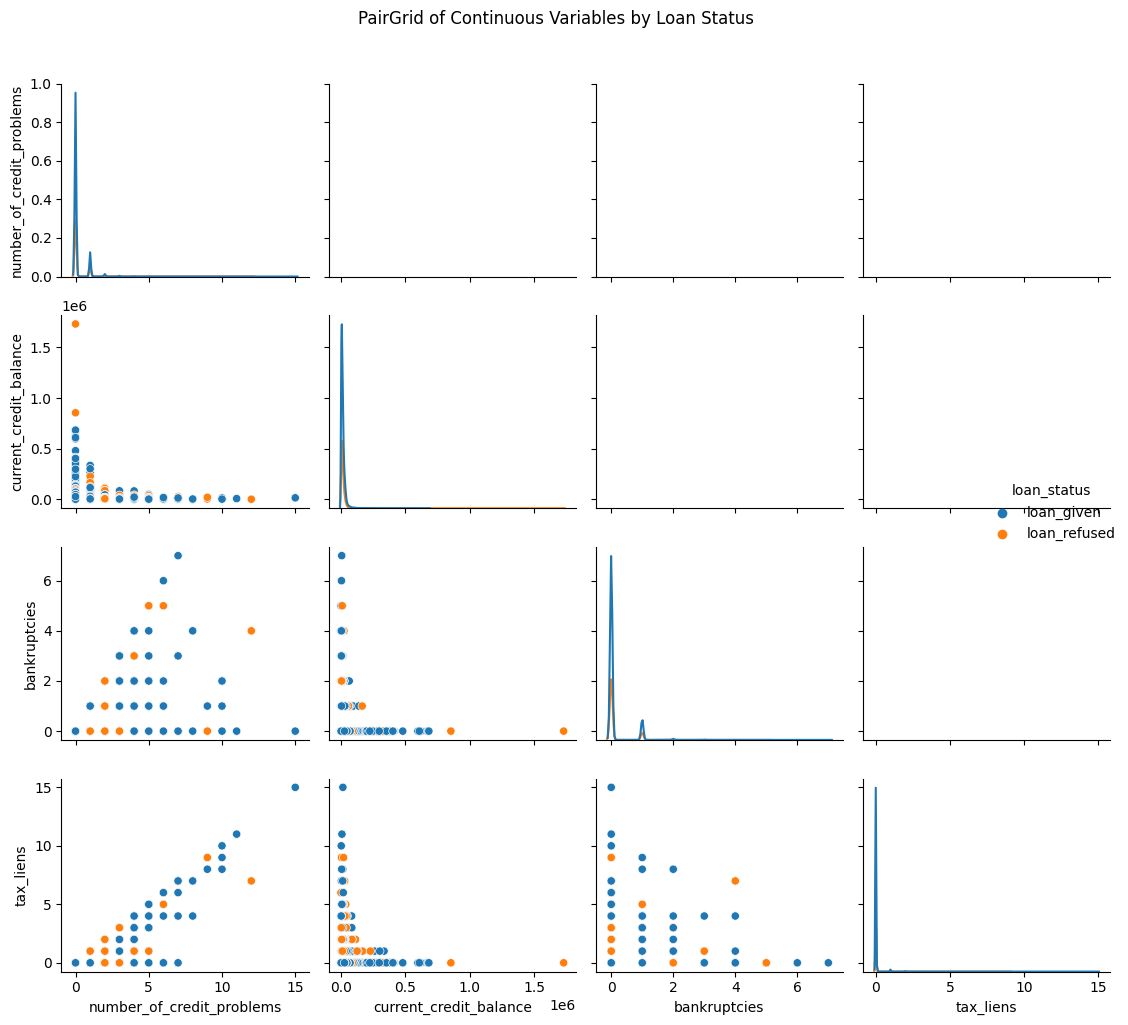

In [38]:
continuous_vars = ['number_of_credit_problems', 'current_credit_balance', 'bankruptcies', 'tax_liens']

# Create a pair grid with loan_status as hue
g = sns.PairGrid(df_agg, vars=continuous_vars, hue='loan_status', diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend()
plt.suptitle("PairGrid of Continuous Variables by Loan Status", y=1.02)
plt.tight_layout()
plt.show();

The diagonal part of the pair grid is a KDE plot, which is a smoothened version of a histogram. The ones below the KDE plots indicate the relationship between variables. The one indicating that it has somewhat linear relationship is the number_of_credit_problems and the tax_liens. The rest, judging by the patterns indicate that there are correlations, although they might not be linear.

These strong correlations might cause multicollinearity problems. Especially since I plan to use gradient boosting model and XGBoost in training the models. I will note this and try to eliminate the problem when doing the feature engineering and feature selection.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98579 entries, 0 to 111104
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_id                       98579 non-null  object 
 1   customer_id                   98579 non-null  object 
 2   loan_status                   98579 non-null  object 
 3   current_loan_amount           98579 non-null  int64  
 4   term                          98579 non-null  object 
 5   credit_score                  77241 non-null  float64
 6   years_in_current_job          94404 non-null  object 
 7   home_ownership                98579 non-null  object 
 8   annual_income                 77241 non-null  float64
 9   purpose                       98579 non-null  object 
 10  monthly_debt                  98579 non-null  float64
 11  years_of_credit_history       98579 non-null  float64
 12  months_since_last_delinquent  45476 non-null  float64
 13  numbe

Now that we've established the relationship between the continuous variables, it's time to examine the relationship between these continuous variables to loan_status as the target variable. To do that, I will create a facet grid comparing the violin plots between the variables. The left plot will be the distribution of variables when the loan is given, and the right one is when the loan is refused.

To make the plot more readable, I will not plot all variables at once. 3 violin plots per row should be good enough to look at the data distributions. 

First, I will create a function to create the facet grid, then I will plot the data. 

In [40]:
def create_facet_grid(df, continuous_vars, target):
    # Standardize the continuous variables
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[continuous_vars])

    # Create a new DataFrame with the standardized values
    df_standardized = pd.DataFrame(df_scaled, columns=continuous_vars)

    # Add 'loan_status' column back to the DataFrame
    df_standardized[target] = df[target]

    # Melt the data for FacetGrid
    df_melted = df_standardized.melt(id_vars=[target], value_vars=continuous_vars, var_name='variable', value_name='value')

    # Create a FacetGrid with violin plots
    g = sns.FacetGrid(df_melted, col=target, col_wrap=2, height=6)
    g.map(sns.violinplot, 'variable', 'value', inner='quartile', palette='Set1')
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("", "Standardized Value")
    g.set_xticklabels(rotation=45)
    g.tight_layout()
    plt.suptitle(f"Violin Plots of Standardized Continuous Variables by {target.replace('_', ' ').title()}", y=1.02)
    plt.show()

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
The figure layout has changed to tight


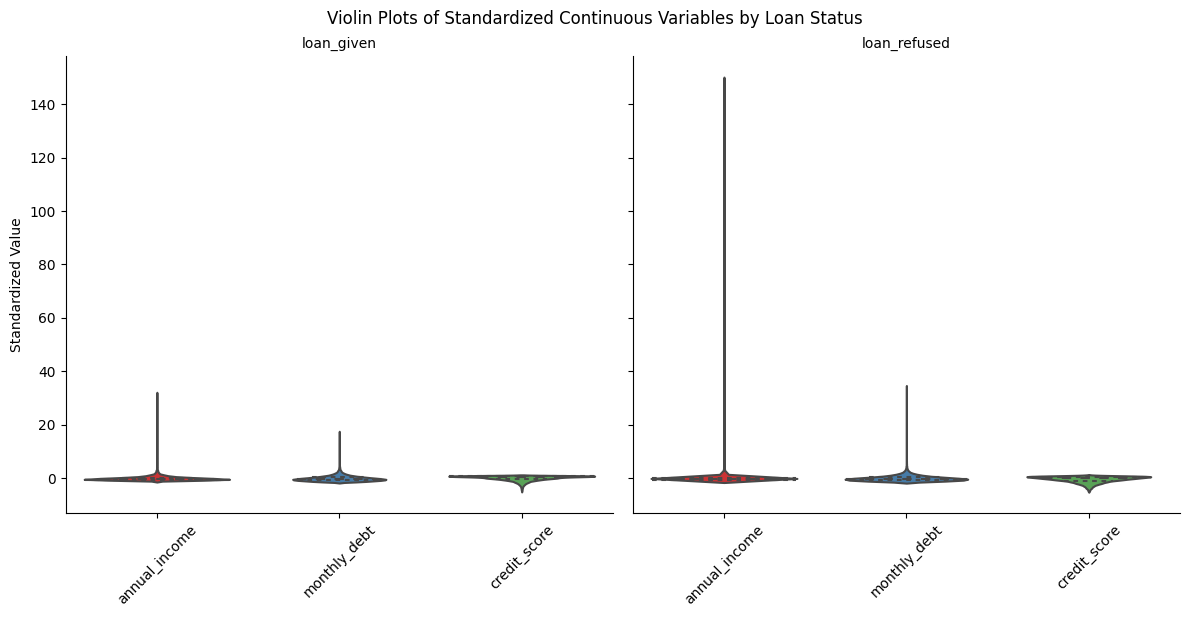

In [41]:
continuous_cols = ['annual_income', 'monthly_debt', 'credit_score']
create_facet_grid(df_agg, continuous_cols, 'loan_status')

Since there are outliers present, it's difficult to look at the shape of the violin plots. Thus, I will clip the outliers first, and copy the resulting dataframe into a new dataframe. This is because what I want to do now is to examine visually whether there are strong correlations between each continuous variable to loan_status. However, I still want to use these outliers in model creation later.

In [42]:
def clip_outliers(df, col: str):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    upper_threshold = q3 + (1.5 * (q3 - q1))
    df[col] = df[col].clip(upper=upper_threshold)

In [43]:
#copy df_agg to df_plot, because df_agg will be used to build the ML model
df_plot = df_agg.copy()

#clip the outliers
continuous_cols = ['current_loan_amount', 'credit_score', 'annual_income', 'monthly_debt', 'years_of_credit_history', 'months_since_last_delinquent', 'number_of_open_accounts', 'number_of_credit_problems', 'current_credit_balance', 'maximum_open_credit', 'bankruptcies', 'tax_liens']
for col in continuous_cols:
    clip_outliers(df_plot, col)

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
The figure layout has changed to tight


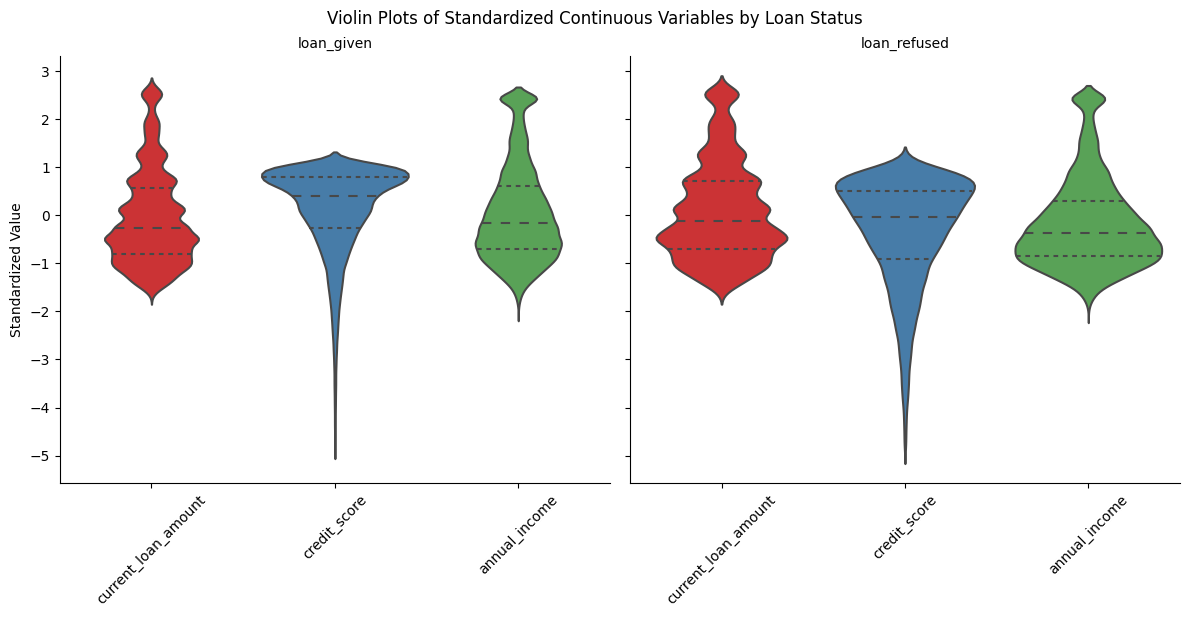

In [44]:
continuous_cols = ['current_loan_amount', 'credit_score', 'annual_income']
create_facet_grid(df_plot, continuous_cols, 'loan_status')

For the current_loan_amount and annual income variables, the violin plot between loan_given and loan_refused is a bit different. There are differences in the distribution around the 25% and 75% quantile. This means that visually, there sholud be a significant difference between the data distribution of current_loan_amount whether the loan is given or refused. These variables might be strong predictors of loan status.

The distribution of credit score between the loans that are given and refused seems a bit different. Most people who get the loan have high credit score. However, most people who get the loan refused also have high credit score. Although, we can see that the median of credit score is higher in when the loan is given compared to when the loan is refused. Furthermore, there are a lot more people with lower credit scores who get their loan refused.

This difference in distribution indicates that credit score is a good predictor of whether a loan is given or refused.

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
The figure layout has changed to tight


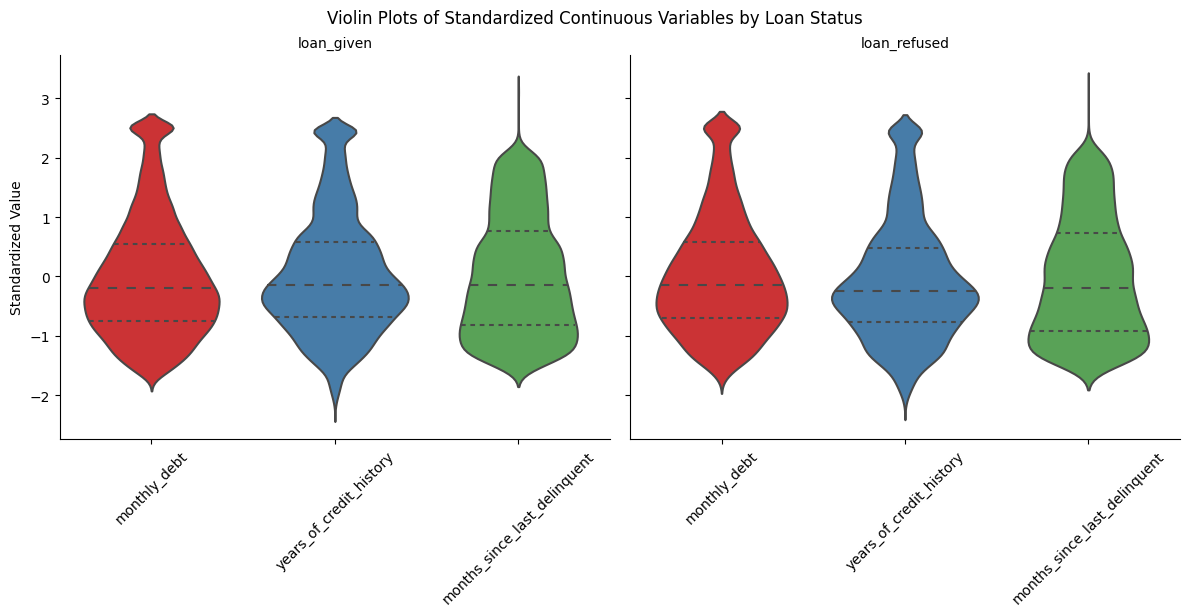

In [45]:
continuous_cols = ['monthly_debt', 'years_of_credit_history', 'months_since_last_delinquent']
create_facet_grid(df_plot, continuous_cols, 'loan_status')

Visually, there are slight differences between the shape of the plots of these 3 variables. Although the differences are not as clear as the previous violin plots, I can still see the differences. All quantiles seem to be identical, only the shape (the distributions) are different. This indicate that these 3 variables might be a good predictor of loan_status, although not quite as strong as the previous ones.

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
The figure layout has changed to tight


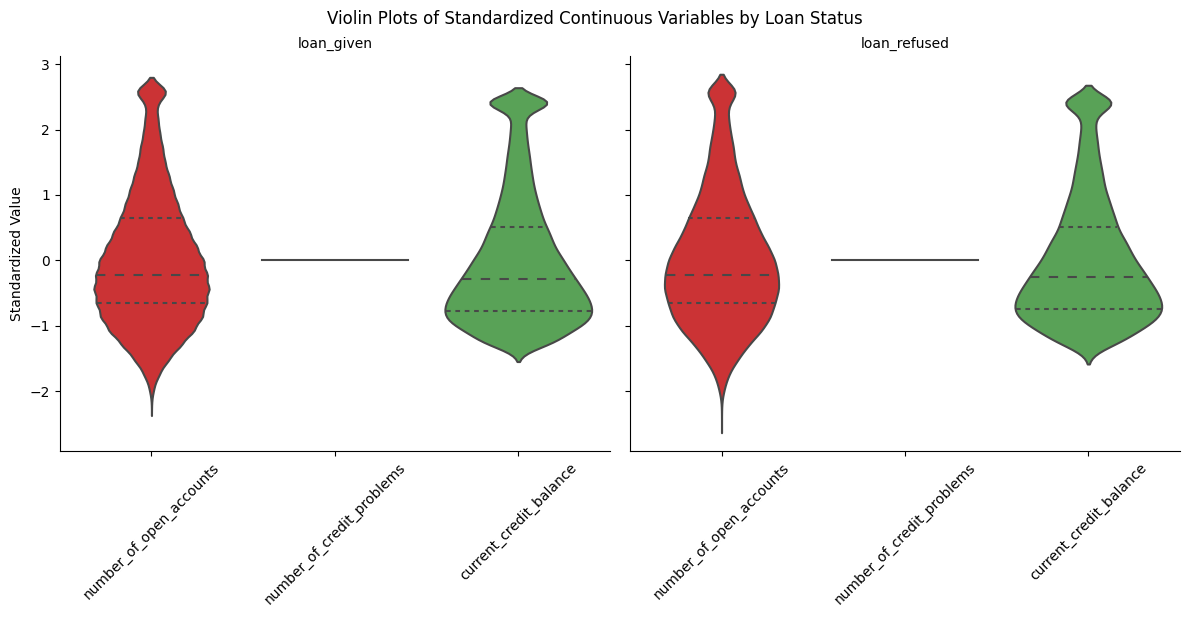

In [46]:
continuous_cols = ['number_of_open_accounts', 'number_of_credit_problems', 'current_credit_balance']
create_facet_grid(df_plot, continuous_cols, 'loan_status')

The violin plot for the number_of_open_account is a bit different, especially in the between the min and 25% quantiles and the 75% to max quantiles. The rest is quite similar, although there is a difference in shape. Again, this variable might be a good predictor of loan_status.

The same goes for current_credit balance. The distributions between the min and 25% quantiles and 75% to max quantiles are visibly different. This variable might also be a good predictor of loan_status.

For the number_of_credit_problems, it's difficult to see the distribution and whether it's different between loan_given and loan_refused. I will deal with this variable later.

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
The figure layout has changed to tight


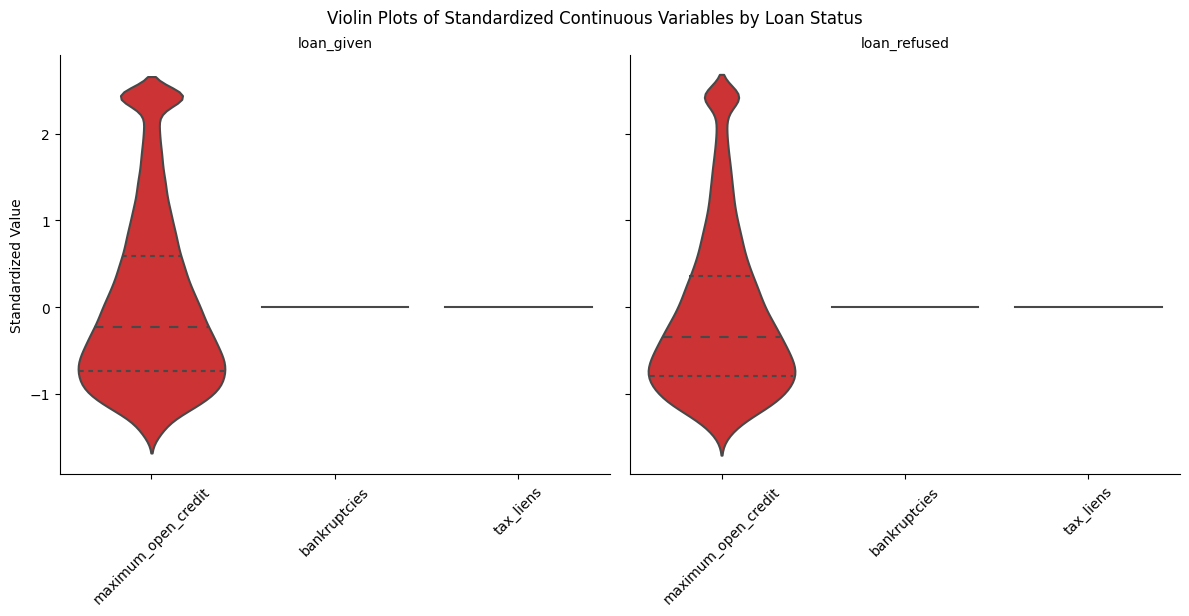

In [47]:
continuous_cols = ['maximum_open_credit', 'bankruptcies', 'tax_liens']
create_facet_grid(df_plot, continuous_cols, 'loan_status')

The data distribution for the maximum_open_credit variable is also visibly different, especially around the 50% area. The rest is also different, indicating that this variable might be a strong predictor for loan_status.

As for bankruptcies and tax_liens, the distributions are unclear, and I can't compare them between loan_given and loan_refused. 

There are 3 continuous variables with unclear violin plots, which are number_of_credit_problems, bankruptcies, and tax_liens. I will create a side-by-side violin plot and box plot using the original (non-standardized) data to look at the shape.

In [48]:
def create_box_violin_plot(df,x,y):
    fig,axes=plt.subplots(1,2,figsize=(18,10))
    fig.suptitle("Violin and box plots for variable : {}".format(y))
    sns.violinplot(ax=axes[0],x=x,y=y,data=df)
    sns.boxplot(ax=axes[1],data=df[y])

    axes[0].set_title(f"Violin plot for variable {y} and its relation with {x}")
    axes[1].set_title(f"Box plot for variable {y}")
    
    plt.show();

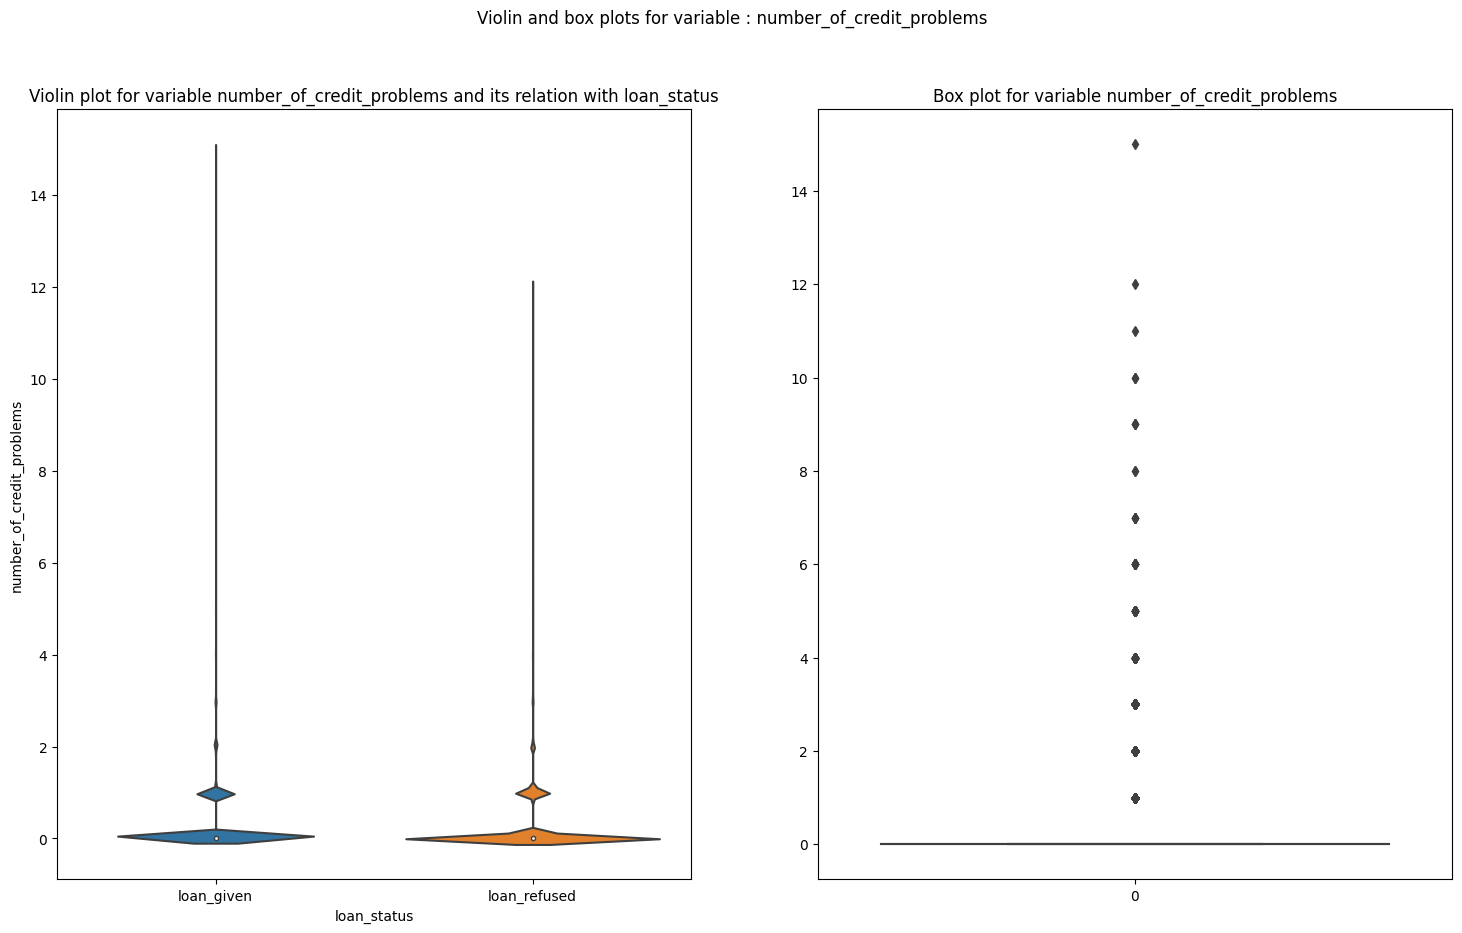

In [49]:
create_box_violin_plot(df_agg, 'loan_status', 'number_of_credit_problems')

Based on the box plot, I can see that most people have no credit problems. This is what caused the difficulties in reading the violin plot for this variable. The data distribution seems to be similar, although the maximum value is different between loan_given and loan_refused. This variable might not be the strongest predictor for loan_status, especially because most people don't have credit problems.

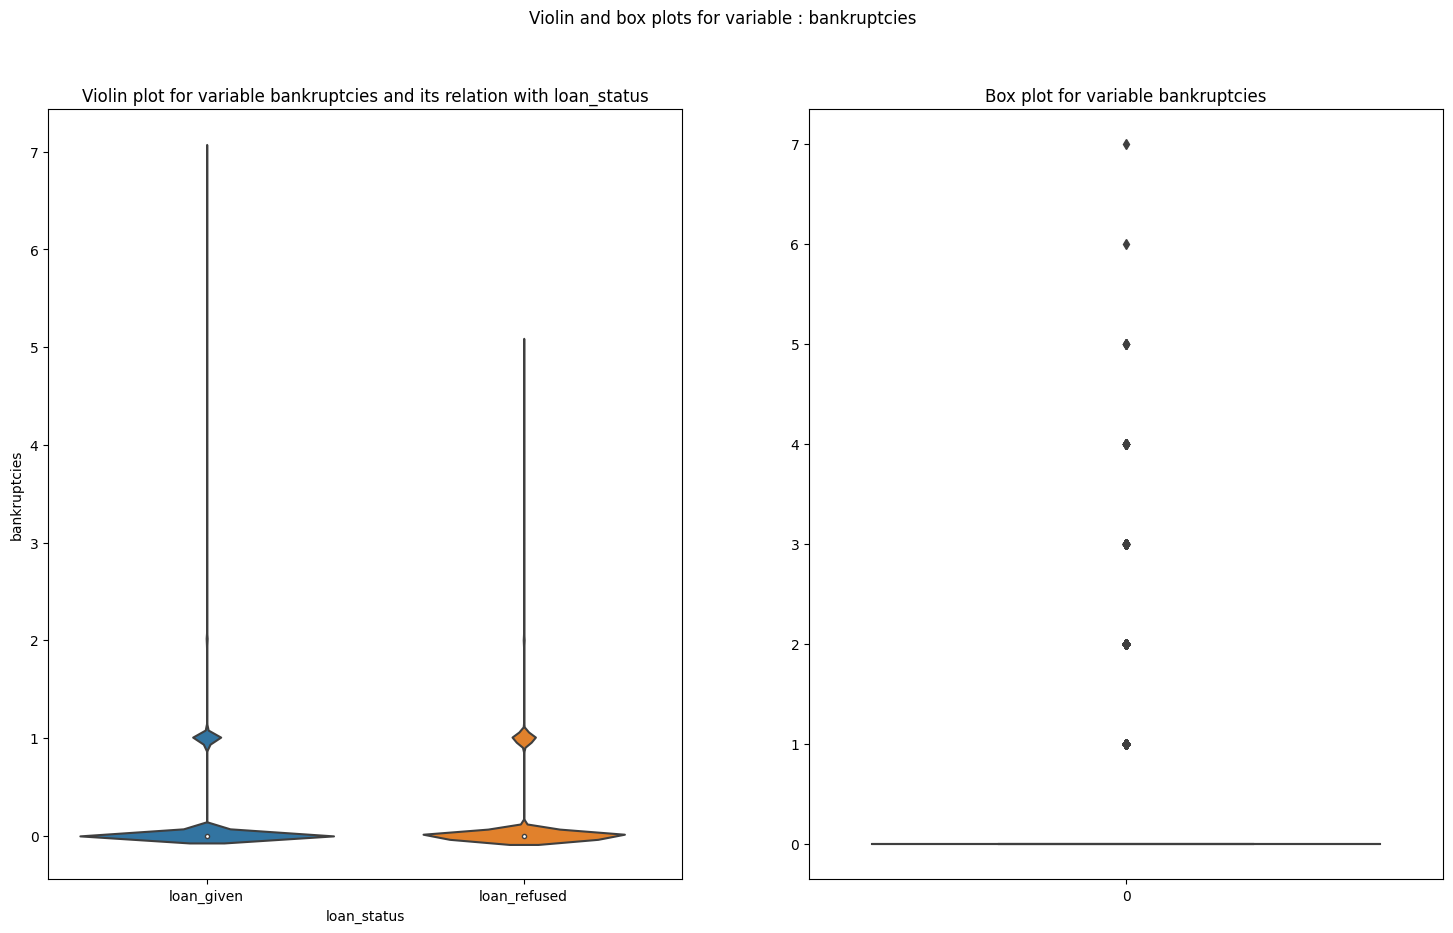

In [50]:
create_box_violin_plot(df_agg, 'loan_status', 'bankruptcies')

Similar to the previous plots, most people who applied for the loans haven't declared bankruptcies. The difference between the violin plot is again the max values. The distribution is similar, indicating that this might not be the strongest predictor of loan_status. Especiallty because most people haven't declared bankruptcies.

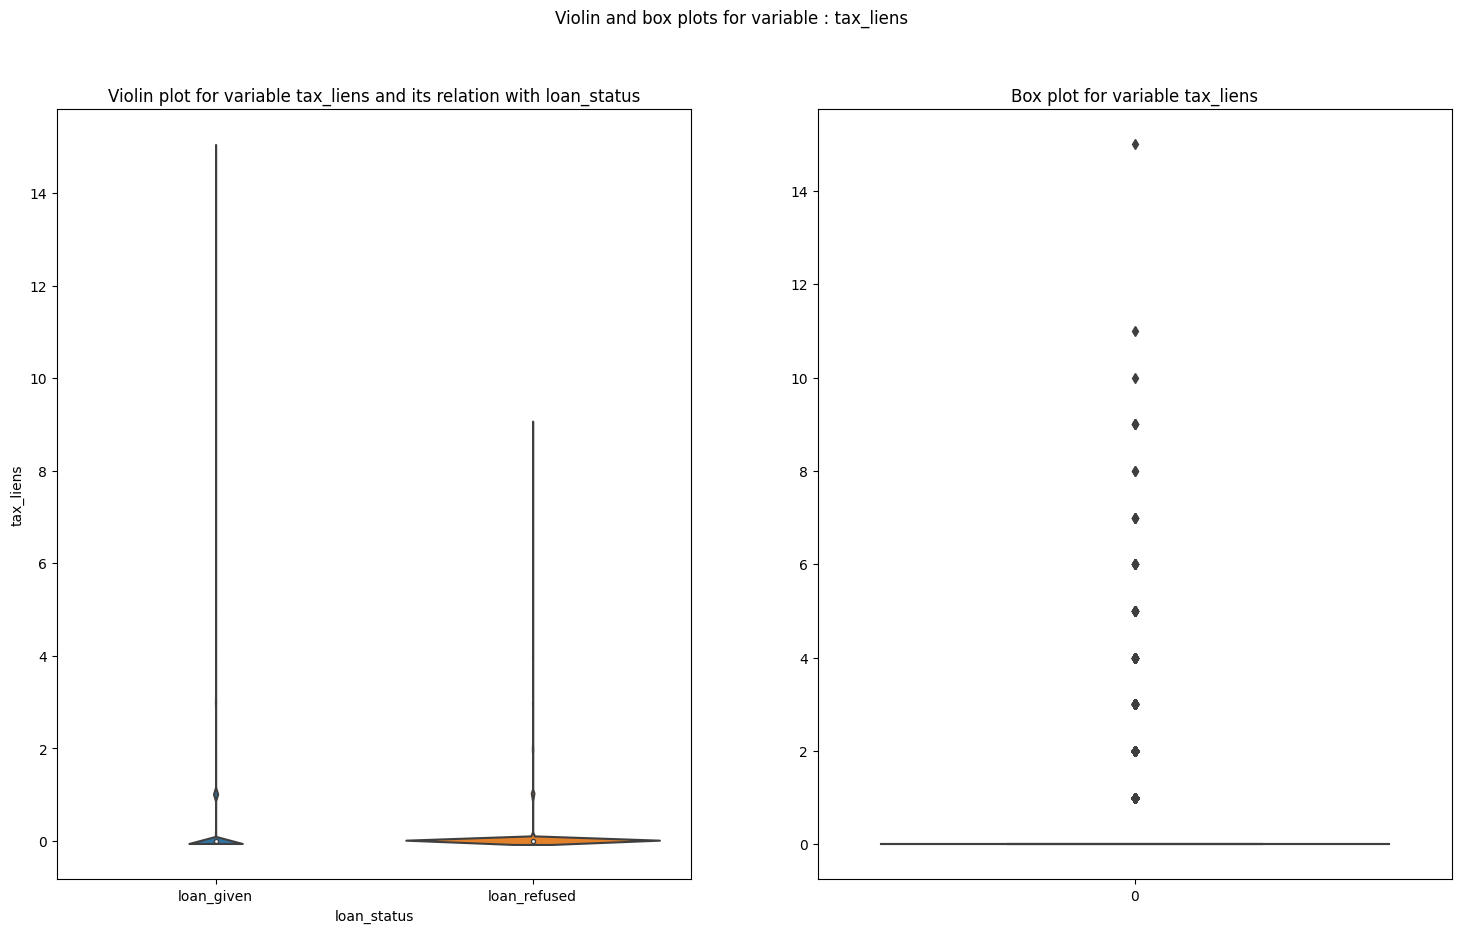

In [51]:
create_box_violin_plot(df_agg, 'loan_status', 'tax_liens')

This plot is similar to the previous 2 plots, with an outlier visibly present. The distribution is quite different around the 0 point (people who don't have tax_liens). However, since most of the people don't have tax_liens, this might not be the best predictor for loan_status.


# Data preprocessing and imputation
After examining the relationship between variables, I will preprocess the data and impute the missing values before building the model. The tasks at hand are:
1. Convert term into 0 and 1. 0 indicate short term loans, and 1 indicates long term loans.
2. Do one-hot-encode for home_ownership and purpose, and converting True to 1, and False to 0. Purposefully, I don't one-hot-encode the years_in_current_job variable because this variable represents year and I want to keep the ordinal information in this variable.
3. Impute missing values. For the sake of time, I will use KNNImputer to do the data imputation.
4. Scale continuous variables which need scaling. This is to make the training faster.
5. Drop loan_id and customer_id column. I won't need these columns for building the machine learning model.

Afterwards, I will save this dataframe into a final dataframe which will be used for building the machine learning model.

In [52]:
#clean term
term_dict = {'short_term':0, 'long_term':1}
df_agg.replace({"term": term_dict}, inplace=True)

In [53]:
df_agg.term.value_counts()

term
0    66931
1    21977
Name: count, dtype: int64

In [54]:
#checking missing values
df_agg.isnull().sum()

loan_id                             0
customer_id                         0
loan_status                         0
current_loan_amount              8316
term                                0
credit_score                    16089
years_in_current_job             3817
home_ownership                      0
annual_income                   16089
purpose                             0
monthly_debt                        0
years_of_credit_history             0
months_since_last_delinquent    48506
number_of_open_accounts             0
number_of_credit_problems           0
current_credit_balance              0
maximum_open_credit               892
bankruptcies                      192
tax_liens                           8
dtype: int64

In [55]:
#impute using KNNImputer
imputer = KNNImputer(n_neighbors=5)
column_names_to_impute = ['current_loan_amount', 'credit_score', 'years_in_current_job', 'annual_income', 'months_since_last_delinquent', 'maximum_open_credit', 'bankruptcies', 'tax_liens']
imputed = imputer.fit_transform(df_agg[column_names_to_impute].values)

joblib.dump(imputer, 'model/knn_imputer_model.pkl')

data_temp = pd.DataFrame(imputed, columns=column_names_to_impute, index = df_agg.index)
df_agg[column_names_to_impute] = data_temp

#sanity checking
df_agg.isnull().sum()

loan_id                         0
customer_id                     0
loan_status                     0
current_loan_amount             0
term                            0
credit_score                    0
years_in_current_job            0
home_ownership                  0
annual_income                   0
purpose                         0
monthly_debt                    0
years_of_credit_history         0
months_since_last_delinquent    0
number_of_open_accounts         0
number_of_credit_problems       0
current_credit_balance          0
maximum_open_credit             0
bankruptcies                    0
tax_liens                       0
dtype: int64

In [56]:
#save the data for feature engineering later
df_agg.to_csv('data/non_standardized_data.csv', index = False)

In [57]:
#create dummies variable (one hot encode)
dummies = pd.get_dummies(df_agg['purpose'], prefix='purpose', drop_first = True)
df_agg[dummies.columns] = dummies

dummies = pd.get_dummies(df_agg['home_ownership'], prefix='home', drop_first = True)
df_agg[dummies.columns] = dummies

df_agg = df_agg.drop(["home_ownership", "purpose"], axis=1)
df_agg = df_agg.replace({True: 1, False: 0})

In [58]:
cols_to_standardize = ['current_loan_amount', 'credit_score', 'annual_income', 'monthly_debt', 'years_of_credit_history', 'months_since_last_delinquent', 'number_of_open_accounts', 'number_of_credit_problems', 'current_credit_balance', 'maximum_open_credit', 'bankruptcies', 'tax_liens']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_agg[cols_to_standardize].values)

data_temp = pd.DataFrame(data_scaled, columns=cols_to_standardize, index = df_agg.index)
df_agg[cols_to_standardize] = data_temp

In [59]:
#save the scaler
scaler_filename = 'model/scaler.pkl'
joblib.dump(scaler, scaler_filename)

['model/scaler.pkl']

In [60]:
df_agg.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,annual_income,monthly_debt,years_of_credit_history,...,purpose_medical_bills,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_take_a_trip,purpose_vacation,purpose_wedding,home_own_home,home_rent
0,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,loan_given,-0.325869,0,0.803162,4.0,-0.553705,-0.953554,-0.966826,...,0,0,0,0,0,0,0,0,0,1
1,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,loan_refused,1.269532,1,0.758483,6.0,0.201945,-0.660059,-0.101477,...,0,0,0,0,0,0,0,0,0,1
2,00020fb0-6b8a-4b3a-8c72-9c4c847e8cb6,c9decd06-16f7-44c3-b007-8776f2a9233d,loan_given,0.576656,0,0.654231,3.0,-0.308392,-0.596454,1.203640,...,0,0,0,0,0,0,0,0,0,0
3,00045ecd-59e9-4752-ba0d-679ff71692b3,b7bce684-b4b0-4b29-af66-eae316bce573,loan_given,-0.309521,0,0.356368,10.0,-0.234440,-0.162871,1.700152,...,0,0,0,0,0,0,0,0,1,0
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,loan_given,-0.079661,0,-0.015960,1.0,-0.815549,-0.291305,-0.668919,...,0,0,0,0,0,0,0,0,1,0


In [61]:
df_agg.drop(['loan_id', 'customer_id'], axis = 1, inplace = True)
df_agg.to_csv('data/final_data.csv', index = False)

Since the data is ready, I will continue to build the machine learning model using H2O and XGBoost in the next notebook.